## Intro
Нужно попробовать YOLO для ускорения

In [0]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle
from glob import glob
import cv2
from google.colab.patches import cv2_imshow

%matplotlib inline
print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.5.0+cu101 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


### Clone repository

In [0]:
!git clone https://github.com/ultralytics/yolov3  # clone

Cloning into 'yolov3'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 9215 (delta 3), reused 6 (delta 2), pack-reused 9203
Receiving objects: 100% (9215/9215), 7.15 MiB | 14.92 MiB/s, done.
Resolving deltas: 100% (6341/6341), done.


In [0]:
!git clone https://github.com/82492749123082/farich-pics.git -b dev #clone dev-branch
!pip install gdown -q #install package
url_dataset, dataset_path = "1V1r0P1QMRpoYhI1tKcGnWXEjdutjXcIV", "dataset.pkl"
!gdown --id $url_dataset -O $dataset_path

Cloning into 'farich-pics'...
remote: Enumerating objects: 180, done.
remote: Counting objects: 100% (180/180), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 469 (delta 50), reused 145 (delta 20), pack-reused 289
Receiving objects: 100% (469/469), 8.99 MiB | 18.42 MiB/s, done.
Resolving deltas: 100% (183/183), done.
Downloading...
From: https://drive.google.com/uc?id=1V1r0P1QMRpoYhI1tKcGnWXEjdutjXcIV
To: /content/dataset.pkl
99.2MB [00:00, 103MB/s] 


## YOLO data

In [0]:
%cd farich-pics

/content/farich-pics


In [0]:
from scipy import sparse
with open('../'+dataset_path, "rb") as f:
    H_res, h_res, mask_res = pickle.load(f)

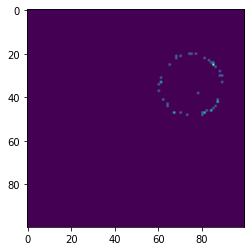

In [0]:
plt.imshow(H_res[2].toarray())

In [0]:
!mkdir /content/boards
!mkdir /content/boards/images
!mkdir /content/boards/labels
!mkdir /content/boards/validation_set

In [0]:
def boards2yolo():
    size = H_res[0].shape[0] #square board (no rectangle)
    for i in range(len(H_res)-200):
        d = H_res[i].toarray()
        d += np.random.poisson(0.05, H_res[i].shape)
        d = d*255/d.max()
        circles = h_res[i].copy()/size
        cv2.imwrite(f'/content/boards/images/{i}.png', cv2.resize(d, (128, 128)))
        with open(f'/content/boards/labels/{i}.txt', 'w') as f:
            for circle in circles:
                f.write( f'{0} {circle[0]} {circle[1]} {circle[2]*2} {circle[2]*2}\n' )
    files = glob('/content/boards/images/*.png')
    train_set = files[:int(0.7*len(files))]
    test_set = files[int(0.7*len(files)):]
    with open('/content/train.txt', 'w') as ftxt:
        for path in train_set:
            ftxt.write( f'{path}\n' )
    with open('/content/test.txt', 'w') as ftxt:
        for path in test_set:
            ftxt.write( f'{path}\n' )
    with open('/content/boards.names', 'w') as ftxt:
        ftxt.write('ring\n')
    with open('/content/boards.data', 'w') as ftxt:
        ftxt.write('classes=1\n')
        ftxt.write('train=/content/train.txt\n')
        ftxt.write('valid=/content/test.txt\n')
        ftxt.write('names=/content/boards.names\n')
    for i in range(len(H_res)-200, len(H_res)):
        d = H_res[i].toarray()
        d += np.random.poisson(0.05, H_res[i].shape)
        d = d*255/d.max()
        cv2.imwrite(f'/content/boards/validation_set/{i}.png', d)

In [0]:
boards2yolo()

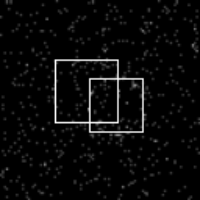

In [0]:
ind0 = 678
i0 = cv2.imread(f'/content/boards/images/{ind0}.png', 0)
for coo in h_res[ind0]:
    x, y, r = list(map(int, coo*1.28))#because of resize to 128
    i0 = cv2.rectangle(i0, (x-r,y-r), (x+r,y+r), (255, 0, 0), 1)
i0 = cv2.resize(i0, (200, 200))
cv2_imshow(i0)

Update yolov3-spp.cfg

Update the settings to filters=[5 + n] * 3 and classes=n, where n is your class count. This modification should be made in all 3 YOLO layers.

In [0]:
%cd ../yolov3

/content/yolov3


In [0]:
url_dataset, dataset_path = "10m_3MlpQwRtZetQxtksm9jqHrPTHZ6vo", "weights/yolov3_tiny.pt"
!gdown --id $url_dataset -O $dataset_path

Downloading...
From: https://drive.google.com/uc?id=10m_3MlpQwRtZetQxtksm9jqHrPTHZ6vo
To: /content/yolov3/weights/yolov3_tiny.pt
35.4MB [00:00, 85.4MB/s]


(OPTIONAL) Update hyperparameters such as LR, LR scheduler, optimizer, augmentation settings, multi_scale settings, etc in train.py for your particular task. We recommend you start with all-default settings first updating anything.

!!!**decrease giou gain in train.py**

In [0]:
!python train.py --cfg yolov3-tiny3-1cls.cfg --data ../boards.data  --epochs 200 --device 0 \
--batch-size 48 --img-size 128 --weights weights/yolov3_tiny.pt

Apex recommended for faster mixed precision training: https://github.com/NVIDIA/apex
Namespace(adam=False, batch_size=48, bucket='', cache_images=False, cfg='./cfg/yolov3-tiny3-1cls.cfg', data='../boards.data', device='0', epochs=200, evolve=False, img_size=[128], multi_scale=False, name='', nosave=False, notest=False, rect=False, resume=False, single_cls=False, weights='weights/yolov3_tiny.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

Start Tensorboard with "tensorboard --logdir=runs", view at http://localhost:6006/
2020-05-29 03:20:56.145892: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Model Summary: 45 layers, 9.00039e+06 parameters, 9.00039e+06 gradients
Optimizer groups: 16 .bias, 16 Conv2d.weight, 13 other
111 /content/train.txt /content/
['/content/boards/images/4448.png', '/content/boards/images/5528.png', '/content/boards/images/5336.png', '/content/boa

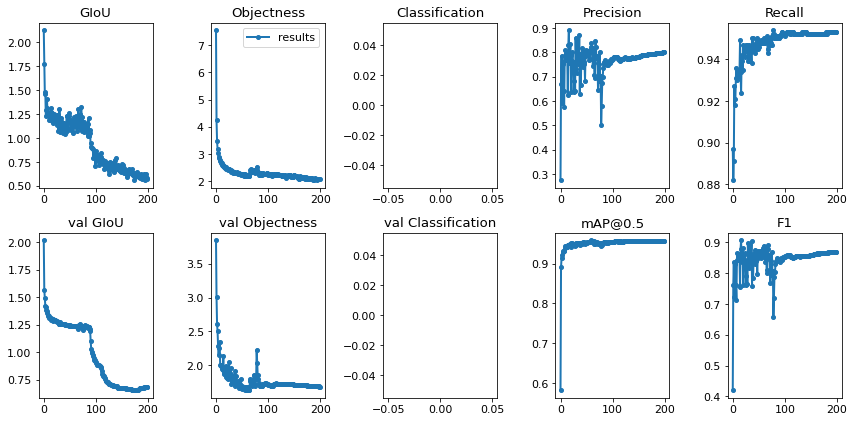

In [0]:
from utils import utils
utils.plot_results()

In [0]:
%ls

cfg/        models.py*         results.txt           train_batch0.jpg
data/       output/            runs/                 train.py
detect.py   __pycache__/       test_batch0_gt.jpg    tutorial.ipynb
Dockerfile  README.md*         test_batch0_pred.jpg  utils/
LICENSE     requirements.txt*  test.py               weights/


In [0]:
!python detect.py --source ../boards/validation_set/ --img-size 128 --names ../boards.names --cfg yolov3-tiny3-1cls.cfg --weights ./weights/last.pt

Namespace(agnostic_nms=False, augment=False, cfg='./cfg/yolov3-tiny3-1cls.cfg', classes=None, conf_thres=0.3, device='', fourcc='mp4v', half=False, img_size=1024, iou_thres=0.6, names='./../boards.names', output='output', save_txt=False, source='../boards/validation_set/', view_img=False, weights='./weights/last.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

Model Summary: 45 layers, 9.00039e+06 parameters, 9.00039e+06 gradients
image 1/200 ../boards/validation_set/9800.png: 1024x1024 238 rings, Done. (0.009s)
image 2/200 ../boards/validation_set/9801.png: 1024x1024 373 rings, Done. (0.009s)
image 3/200 ../boards/validation_set/9802.png: 1024x1024 337 rings, Done. (0.009s)
image 4/200 ../boards/validation_set/9803.png: 1024x1024 310 rings, Done. (0.009s)
image 5/200 ../boards/validation_set/9804.png: 1024x1024 300 rings, Done. (0.009s)
image 6/200 ../boards/validation_set/9805.png: 1024x1024 330 rings, Done. (0.009s)
image 7/200 ../boa

In [0]:
index = 9799

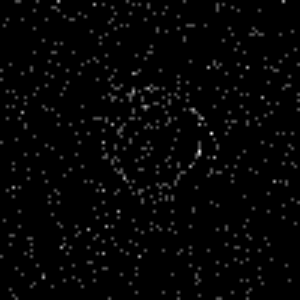

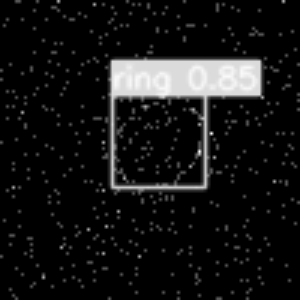

In [0]:
index += 1
source_path = f"../boards/validation_set/{index}.png"
output_path = f"../yolov3/output/{index}.png"
imgIn  = cv2.resize( cv2.imread(source_path, 0), (300, 300), cv2.INTER_LINEAR )
imgOut = cv2.resize( cv2.imread(output_path, 0), (300, 300), cv2.INTER_LINEAR )
cv2_imshow(imgIn)
cv2_imshow(imgOut)